In [1]:
import os
import pickle
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import norm
import numpy as np

from astropy import units as u 
from astropy.table import Table

from snewpy.neutrino import Flavor, MassHierarchy, MixingParameters
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from snewpy.models import Nakazato_2013
from snewpy.models.ccsn import Fornax_2022
from snewpy.models.ccsn import Bollig_2016
from snewpy.models.ccsn import Sukhbold_2015
from snewpy.flavor_transformation import AdiabaticMSW, NonAdiabaticMSWH, \
                                         TwoFlavorDecoherence, ThreeFlavorDecoherence, \
                                         NeutrinoDecay, AdiabaticMSWes, NonAdiabaticMSWes
from asteria import set_rcparams
from asteria.simulation import Simulation


%matplotlib inline

ImportError: DLL load failed while importing _errors: The specified procedure could not be found.

In [3]:
forn_masses=[9,11,13,15,16.99,19.02,21,23,25,26.99]
forn_masses_cut=[9,15,19.02,26.99]

In [4]:
forn_param = list(params for params in Fornax_2022.get_param_combinations() if 
                   params['progenitor_mass'].value in forn_masses)

In [5]:
forn_models=[]
for param in forn_param:
    forn_models.append({
        'name': 'Fornax_2022',
        'param': param
    })

In [6]:
models=[]
for m in forn_masses_cut:
    # Initialize every 20th progenitor.
    models.append(Fornax_2022(progenitor_mass=m*u.solMass))
    
models

[Fornax_2022 Model
 Progenitor mass  : 9.0 solMass
 Black hole       : False
 PNS mass         : 1.35 solMass,
 Fornax_2022 Model
 Progenitor mass  : 15.0 solMass
 Black hole       : True
 PNS mass         : 1.94 solMass,
 Fornax_2022 Model
 Progenitor mass  : 19.02 solMass
 Black hole       : False
 PNS mass         : 1.85 solMass,
 Fornax_2022 Model
 Progenitor mass  : 26.99 solMass
 Black hole       : False
 PNS mass         : 2.2 solMass]

In [7]:
forn_models

[{'name': 'Fornax_2022', 'param': {'progenitor_mass': <Quantity 9. solMass>}},
 {'name': 'Fornax_2022', 'param': {'progenitor_mass': <Quantity 11. solMass>}},
 {'name': 'Fornax_2022', 'param': {'progenitor_mass': <Quantity 13. solMass>}},
 {'name': 'Fornax_2022', 'param': {'progenitor_mass': <Quantity 15. solMass>}},
 {'name': 'Fornax_2022',
  'param': {'progenitor_mass': <Quantity 16.99 solMass>}},
 {'name': 'Fornax_2022',
  'param': {'progenitor_mass': <Quantity 19.02 solMass>}},
 {'name': 'Fornax_2022', 'param': {'progenitor_mass': <Quantity 21. solMass>}},
 {'name': 'Fornax_2022', 'param': {'progenitor_mass': <Quantity 23. solMass>}},
 {'name': 'Fornax_2022', 'param': {'progenitor_mass': <Quantity 25. solMass>}},
 {'name': 'Fornax_2022',
  'param': {'progenitor_mass': <Quantity 26.99 solMass>}}]

In [7]:
labels=['nmo','imo']
hie=['normal','inverted']
forn_sims = {
  9: [],
  11: [],
  13: [],
  15: [],
  16.99: [],
  19.02: [],
  21: [],
  23: [],
  25: [],
  26.99: []
}

for i,mod in enumerate(forn_models):
    for j,lab in enumerate(labels):
        pred = Simulation(model=mod,
                                         distance=10 * u.kpc, 
                                         Emin=0*u.MeV, Emax=100*u.MeV, dE=1*u.MeV,
                                         tmin=-10*u.s,  tmax=10*u.s,    dt=1*u.ms,
                                         mixing_scheme='AdiabaticMSW',
                                         hierarchy=hie[j])
        pred.run()
        with open("{}_M={}_mix={}.pkl".format(mod['name'], mod['param']['progenitor_mass'].value, lab), 'wb') as f:
            pickle.dump(pred, f)
        forn_sims[forn_masses[i]].append(pred)

Expect a reduction in performance and increase in simulation run times.


KeyboardInterrupt: 

In [8]:
labels=['nmo','imo']
hie=['normal','inverted']
forn_sims = {
  9: [],
  11: [],
  13: [],
  15: [],
  16.99: [],
  19.02: [],
  21: [],
  23: [],
  25: [],
  26.99: []
}

for i,mod in enumerate(forn_models):
    for j,lab in enumerate(labels):
        with open("{}_M={}_mix={}.pkl".format(mod['name'], mod['param']['progenitor_mass'].value, lab), 'rb') as f:
            forn_sims[forn_masses[i]].append(pickle.load(f))

In [9]:
def compute_hits(dist,dt,start,end,sim):
    sim.rebin_result(dt)
    sim.scale_result(dist)
    t, hits = sim.detector_signal(dt)
    id5=np.where(t==start)[0][0]
    id6=np.where(t==end)[0][0]
        
    data=hits[id5:id6]+2000
    return data 

In [10]:
def compute_hits_with_bg(dist,dt,start,end,sim):
    sim.rebin_result(dt)
    sim.scale_result(dist)
    t, hits = sim.detector_signal(dt)
    bg1 = sim.detector.i3_bg(dt,size=hits.size) + sim.detector.dc_bg(dt,size=hits.size)
    sig=bg1+hits
    id1=np.where(t==-5*u.s)[0][0]
    id2=np.where(t==-.5*u.s)[0][0]
    id5=np.where(t==start)[0][0]
    id6=np.where(t==end)[0][0]

    mean_under=np.mean(sig[id1:id2])-2000
    data_hits=np.subtract(sig,mean_under)[id5:id6]
    return data_hits

In [11]:
hits_forn = {
  9: [],
  11: [],
  13: [],
  15: [],
  16.99: [],
  19.02: [],
  21: [],
  23: [],
  25: [],
  26.99: []
}

dt=20*u.ms
#max_t_dat = t1[np.argmax(norm_data_hits[0])]
for i,mod in enumerate(forn_masses):
    for j in range(2):
        simm_forn=forn_sims[mod][j]
        hits_forn[mod].append(compute_hits(8*u.kpc,20*u.ms,.02*u.s,.88*u.s,simm_forn)) 

In [12]:
dt=10*u.ms

forn_nh_data = {
  9: [],
  11: [],
  13: [],
  15: [],
  16.99: [],
  19.02: [],
  21: [],
  23: [],
  25: [],
  26.99: []
}

for j,mod in enumerate(forn_masses):
    for i in range(1000):
        data_sim_forn_nh=forn_sims[mod][0]
        forn_nh_data[mod].append(compute_hits_with_bg(9*u.kpc,20*u.ms,.02*u.s,.88*u.s,data_sim_forn_nh))

In [13]:
dt=20*u.ms

forn_ih_data = {
  9: [],
  11: [],
  13: [],
  15: [],
  16.99: [],
  19.02: [],
  21: [],
  23: [],
  25: [],
  26.99: []
}

for j,mod in enumerate(forn_masses):
    for i in range(1000):
        data_sim_forn_ih=forn_sims[mod][1]
        forn_ih_data[mod].append(compute_hits_with_bg(9*u.kpc,20*u.ms,.02*u.s,.88*u.s,data_sim_forn_ih))

In [14]:
forn_sims[9][0].rebin_result(dt)
forn_sims[9][0].scale_result(10*u.kpc)
t, hits = forn_sims[9][0].detector_signal(dt)
id1=np.where(t==-5*u.s)[0][0]
id2=np.where(t==-.5*u.s)[0][0]
id5=np.where(t==.02*u.s)[0][0]
id6=np.where(t==.88*u.s)[0][0]

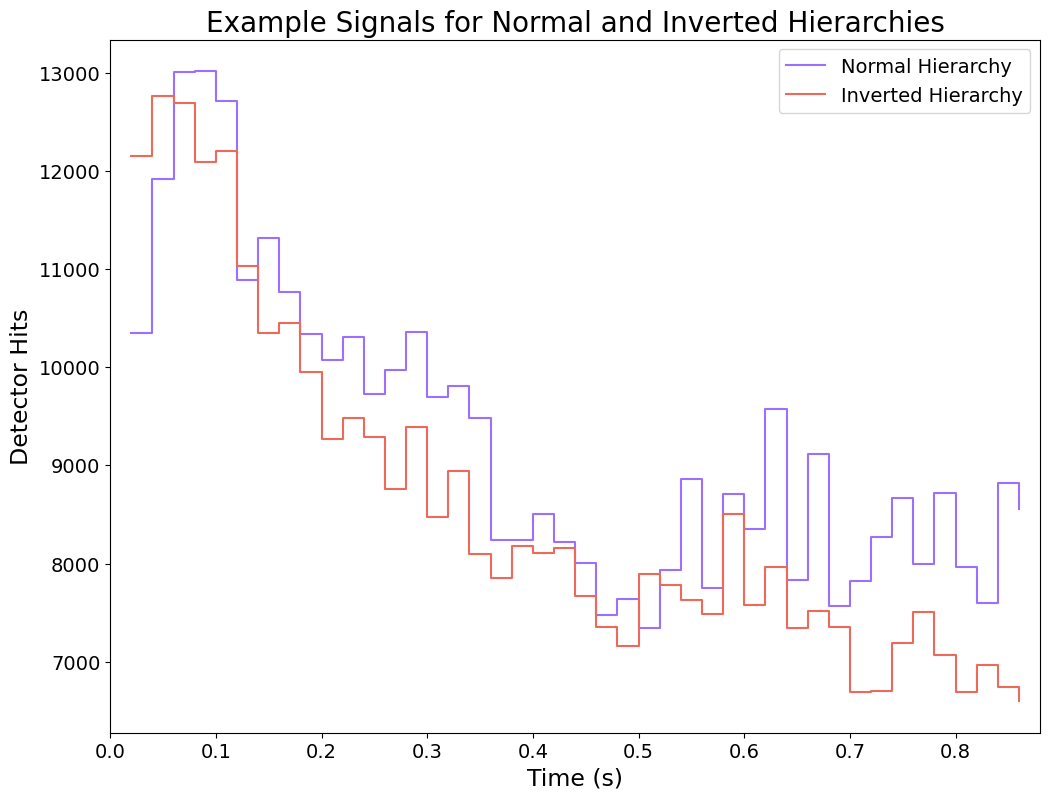

In [25]:
#dt = 10 * u.ms
colors_nmo=['#fc2b1c','#e6e602','#02cf13','#0232cf','#9200b3']
mod_names=['sukh_sfho','sukh_ls220','forn','zha','tamb']

plt.figure(figsize=(12, 9))


#plt.step(t[id5:id6], hits_forn[13][0], where='post',color=colors_nmo[0],label=f'M13 NH')
#plt.step(t[id5:id6], hits_forn[13][1], where='post',color=colors_nmo[1],label=f'M13 IH')

#plt.step(t[id5:id6], hits_forn[23][0], where='post',color=colors_nmo[2],label=f'M23 NH')
#plt.step(t[id5:id6], hits_forn[23][1], where='post',color=colors_nmo[3],label=f'M23 IH')

plt.step(t[id5:id6], forn_nh_data[11][3], where='post',color='#9B70FF',label='Normal Hierarchy')
plt.step(t[id5:id6], forn_ih_data[11][5], where='post',color='#ED6A5A',label='Inverted Hierarchy')
plt.tick_params(axis='both', which='major', labelsize=14)
    
plt.legend(fontsize=14)
plt.xlim(0,.88)
plt.xlabel('Time (s)',fontsize=17)
plt.ylabel('Detector Hits',fontsize=17)
plt.title('Example Signals for Normal and Inverted Hierarchies',fontsize=20)
plt.savefig('norm_inv_mod_dep2.png', dpi=300, bbox_inches='tight')

In [23]:
def compute_chi_sq(pred,dat):
    chi_sq=0
    for i in range(len(pred)):
        chi_sq += ((pred[i]-dat[i])**2)/(dat[i])
    return chi_sq

In [24]:
def compute_p_val(area_tot,start,params,stat,chis_nh,bin_width):
    a,b=params
    upper=-1/a*(5000+b)
    lower=stat
    chis_nh=np.array(chis_nh)
    if(lower<start):
        area=len(chis_nh[np.logical_and(chis_nh>stat,chis_nh<start)])*bin_width+1/a*(np.exp(a*upper+b)-np.exp(a*start+b))
    else:
        area=1/a*(np.exp(a*upper+b)-np.exp(a*lower+b))
    area_full=.9*area_tot*bin_width + 1/a*(np.exp(a*upper+b)-np.exp(a*start+b))
    return area/area_full

In [25]:
def quad_fit(x, a, b):
    return a*x + b

In [26]:
def dist_to_pval_without_plot(data,nh,ih,nbins):
    chis_nh=[]
    chis_ih=[]
    for i, dat in enumerate(data):
        chis_nh.append(compute_chi_sq(nh,dat))
        chis_ih.append(compute_chi_sq(ih,dat))
    
    hist_nh, bin_edges_nh = np.histogram(chis_nh, bins=nbins)
    hist_ih, bin_edges_ih = np.histogram(chis_ih, bins=nbins)
    bin_width_nh = bin_edges_nh[1] - bin_edges_nh[0]
    
    cumulative_nh = np.cumsum(hist_nh)
    split_nh = np.searchsorted(cumulative_nh, .9*len(data))

    tail_region_nh = slice(-(len(hist_nh)-split_nh), None)

    params_nh, cov_nh = curve_fit(quad_fit, bin_edges_nh[tail_region_nh], np.log(hist_nh[tail_region_nh]+1))
    a_nh, b_nh = params_nh
    
    p_vals=[]
    for i,chi_ih in enumerate(chis_ih):
        p=compute_p_val(len(data),bin_edges_nh[split_nh],params_nh,chi_ih,chis_nh,bin_width_nh)
        p_vals.append(p)
        
    x_nh=np.linspace(bin_edges_nh[split_nh],
                     bin_edges_nh[split_nh]+2000,500)
    y_fit_nh = np.exp(a_nh*x_nh+b_nh)
        
    return p_vals

In [27]:
def dist_to_pval_with_plot(data,nh,ih,nbins):
    chis_nh=[]
    chis_ih=[]
    for i, dat in enumerate(data):
        chis_nh.append(compute_chi_sq(nh,dat))
        chis_ih.append(compute_chi_sq(ih,dat))
    
    hist_nh, bin_edges_nh = np.histogram(chis_nh, bins=nbins)
    hist_ih, bin_edges_ih = np.histogram(chis_ih, bins=nbins)
    bin_width_nh = bin_edges_nh[1] - bin_edges_nh[0]
    
    cumulative_nh = np.cumsum(hist_nh)
    split_nh = np.searchsorted(cumulative_nh, .9*len(data))

    tail_region_nh = slice(-(len(hist_nh)-split_nh), None)

    params_nh, cov_nh = curve_fit(quad_fit, bin_edges_nh[tail_region_nh], np.log(hist_nh[tail_region_nh]+1))
    a_nh, b_nh = params_nh
    
    p_vals=[]
    for i,chi_ih in enumerate(chis_ih):
        p=compute_p_val(len(data),bin_edges_nh[split_nh],params_nh,chi_ih,chis_nh,bin_width_nh)
        p_vals.append(p)
        
    x_nh=np.linspace(bin_edges_nh[split_nh],
                     bin_edges_nh[split_nh]+2000,500)
    y_fit_nh = np.exp(a_nh*x_nh+b_nh)
        
    return p_vals,chis_nh,chis_ih,y_fit_nh,x_nh

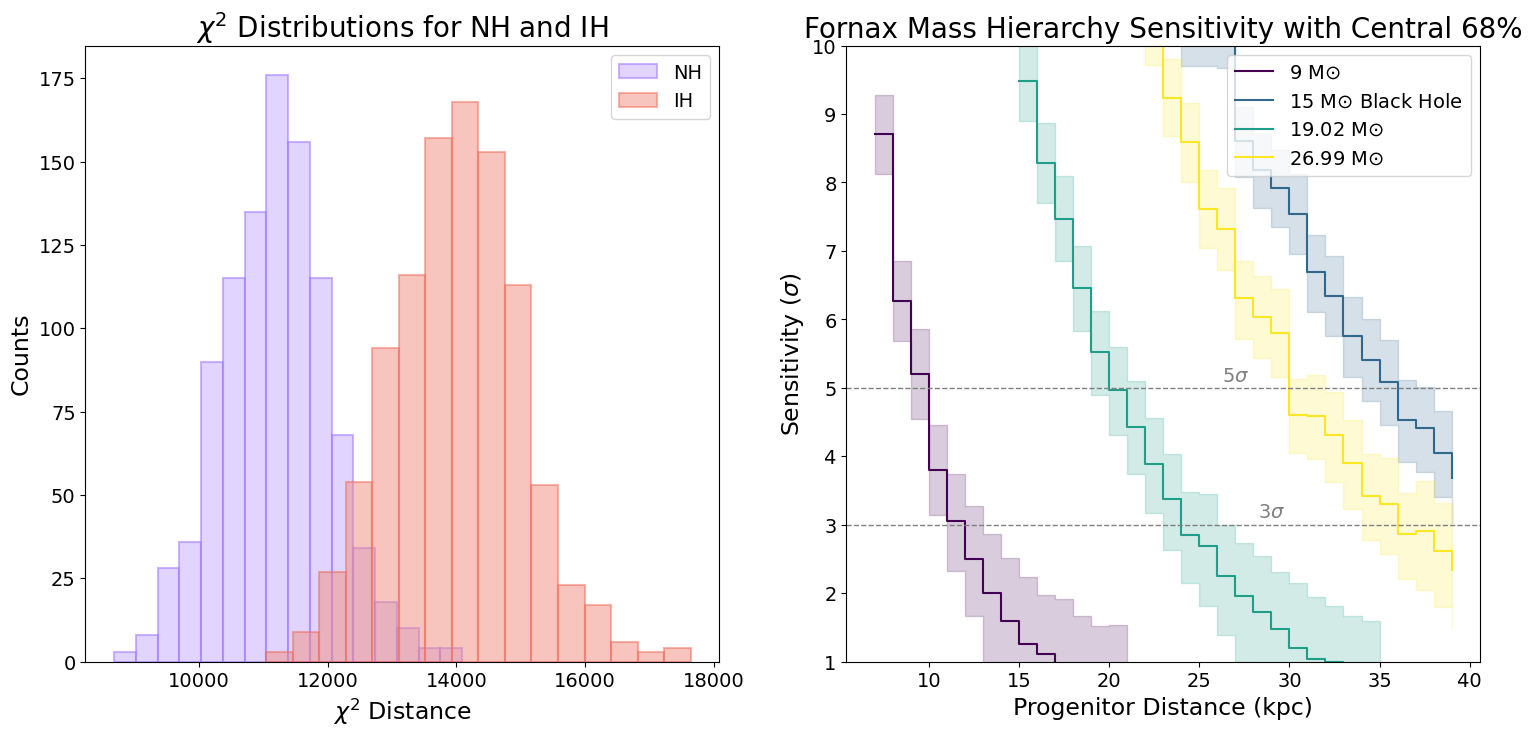

In [34]:
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

cmap = cm.viridis
norm1 = mcolors.Normalize(vmin=min(forn_masses_cut), vmax=max(forn_masses_cut))

axes = axes.flatten()
p_vals,chi_nh,chi_ih,y_fit_nh,x_nh = dist_to_pval_with_plot(forn_nh_data[9],
                                                                      hits_forn[9][0],hits_forn[9][1],24)
axes[0].hist(chi_nh, alpha=0.5, color='#C5ADFF', edgecolor='#9B70FF', 
                linewidth=1.5,label='NH',bins=16)
axes[0].hist(chi_ih, alpha=0.5, color='#F18C7E', edgecolor='#ED6A5A', 
                linewidth=1.5,label='IH',bins=16)

axes[0].legend(fontsize=14)
axes[0].set_xlabel('$\chi^2$ Distance',fontsize=17)
axes[0].set_ylabel('Counts',fontsize=17)
axes[0].set_title('$\chi^2$ Distributions for NH and IH',fontsize=20)
axes[0].tick_params(axis='both', which='major', labelsize=14)


for j,mod in enumerate(forn_masses_cut):
    prec_9_16=[]
    prec_9_84=[]
    sigs_9=[]
    dist_9=[]
    for i,dist in enumerate(forn_dist):
        if(dist[mod][0]<10.5 and dist[mod][0]>.5):
            sigs_9.append(dist[mod][0])
            dist_9.append(i+5)
            prec_9_16.append(dist[mod][1])
            prec_9_84.append(dist[mod][2])
        elif(dist[mod][0]<.5):
            break
            
    color = cmap(norm1(mod))
    if(mod==15):
        axes[1].step(dist_9,sigs_9,color=color,where='post',label='{} M$\odot$ Black Hole'.format(mod))
    else:
        axes[1].step(dist_9,sigs_9,color=color,where='post',label='{} M$\odot$'.format(mod))
    axes[1].fill_between(dist_9, prec_9_16, prec_9_84,step='post',color=color, alpha=0.2)

axes[1].axhline(y=3, color='grey', linestyle='--', linewidth=1)
axes[1].axhline(y=5, color='grey', linestyle='--', linewidth=1)
axes[1].text(27, 5.1, '5$\sigma$', color='grey', ha='center',fontsize=14)
axes[1].text(29, 3.1, '3$\sigma$', color='grey', ha='center',fontsize=14)

axes[1].legend(fontsize=14)
axes[1].set_title('Fornax Mass Hierarchy Sensitivity with Central 68%',fontsize=20)
axes[1].set_ylabel('Sensitivity ($\sigma$)',fontsize=17)
axes[1].set_xlabel('Progenitor Distance (kpc)',fontsize=17)
axes[1].set_ylim(1,10)
axes[1].tick_params(axis='both', which='major', labelsize=14)

plt.savefig('sig_mod_dep.png', dpi=300, bbox_inches='tight')

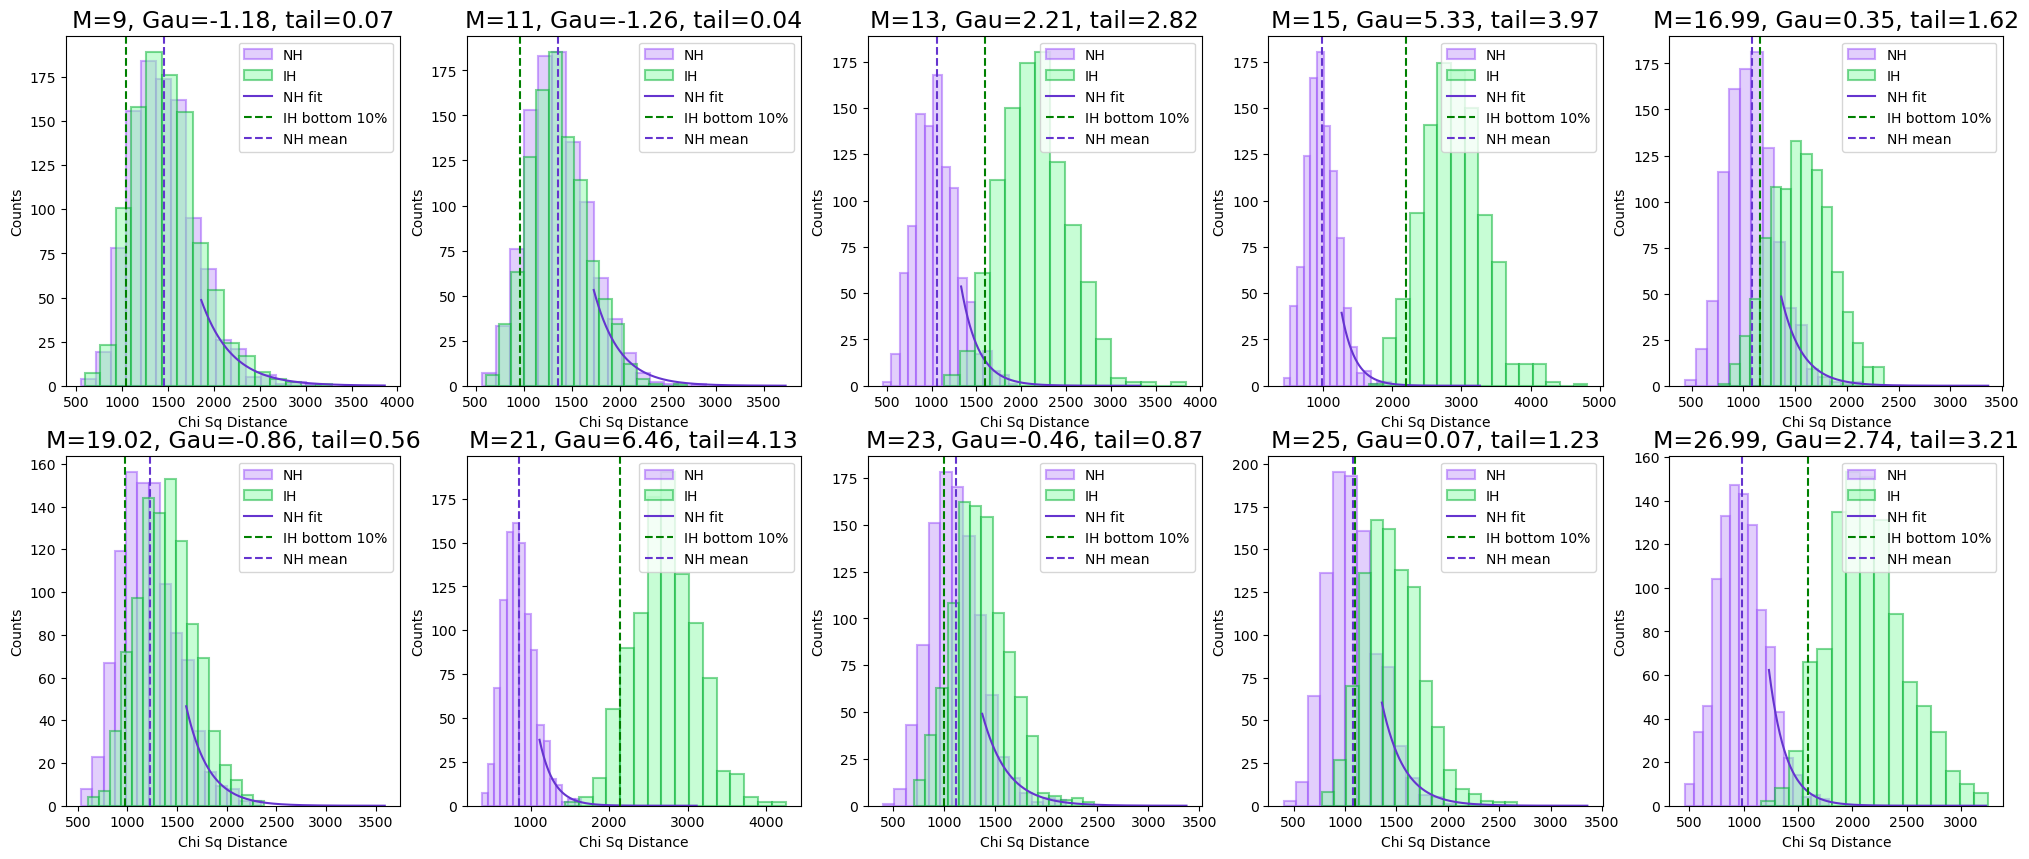

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(25, 10))
axes = axes.flatten()

for i,ax in enumerate(axes):
    m=forn_masses[i]
    p_vals,chi_nh,chi_ih,y_fit_nh,x_nh = dist_to_pval_with_plot(forn_nh_data[m],
                                                                      hits_forn[m][0],hits_forn[m][1],24)
    ax.hist(chi_nh, alpha=0.5, color='#c7a0fa', edgecolor='#9b52fa', 
                linewidth=1.5,label='NH',bins=16)
    ax.hist(chi_ih, alpha=0.5, color='#90fcad', edgecolor='#02b031', 
                linewidth=1.5,label='IH',bins=16)
    ax.plot(x_nh, y_fit_nh, color='#6534cf', label='NH fit')
        
    hist_ih, bin_edges_ih = np.histogram(chi_ih, bins=24)
    cumulative_ih = np.cumsum(hist_ih)
    cutoff_index_ih = np.searchsorted(cumulative_ih, 0.1 * len(forn_nh_data[m]))
    cutoff_value_ih = bin_edges_ih[cutoff_index_ih]
        
    ax.axvline(cutoff_value_ih, color='green', linestyle='--', label='IH bottom 10%')
    ax.axvline(np.mean(chi_nh), color='#6534cf', linestyle='--', label='NH mean')

    s=round((cutoff_value_ih-np.mean(chi_nh))/np.std(chi_nh),2)
        
    ax.legend()
    ax.set_xlabel('Chi Sq Distance')
    ax.set_ylabel('Counts')
    ax.set_title('M={}, Gau={}, tail={}'.format(forn_masses[i],s,
                                                                                     round(norm.isf(np.median(p_vals)),2)),
                    fontsize=17)

In [19]:
forn_dist=[]

for dist in range(5,40):
    print(dist)
    forn_p = {
      9: [],
      11: [],
      13: [],
      15: [],
      16.99: [],
      19.02: [],
      21: [],
      23: [],
      25: [],
      26.99: []
    }
 
    forn_hits = {
      9: [],
      11: [],
      13: [],
      15: [],
      16.99: [],
      19.02: [],
      21: [],
      23: [],
      25: [],
      26.99: []
    }

    forn_nh_data = {
      9: [],
      11: [],
      13: [],
      15: [],
      16.99: [],
      19.02: [],
      21: [],
      23: [],
      25: [],
      26.99: []
    }

    for j,mod in enumerate(forn_masses):
        for i in range(10000):
            data_sim_forn=forn_sims[mod][0]
            forn_nh_data[mod].append(compute_hits_with_bg(dist*u.kpc,20*u.ms,.02*u.s,1*u.s,data_sim_forn))

        for i in range(2):
            simm_forn=forn_sims[mod][i]
            forn_hits[mod].append(compute_hits(dist*u.kpc,20*u.ms,.02*u.s,1*u.s,simm_forn)) 

        p_vals_forn=dist_to_pval_without_plot(forn_nh_data[mod],
                                                                forn_hits[mod][0],forn_hits[mod][1],24)
        forn_p[mod].append(norm.isf(np.median(p_vals_forn)))
        forn_p[mod].append(norm.isf(np.percentile(p_vals_forn, 16)))
        forn_p[mod].append(norm.isf(np.percentile(p_vals_forn, 84)))

    forn_dist.append(forn_p)

5


KeyboardInterrupt: 

In [24]:
np.savez('forn_dist1.npz',forn_dist)

In [20]:
forn_dist=[]

for dist in range(5,40):
    print(dist)
    forn_p = {
      9: [],
      15: [],
      19.02: [],
      26.99: []
    }
 
    forn_hits = {
      9: [],
      15: [],
      19.02: [],
      26.99: []
    }

    forn_nh_data = {
      9: [],
      15: [],
      19.02: [],
      26.99: []
    }
    for j,mod in enumerate(forn_masses_cut):
        for i in range(10000):
            data_sim_forn=forn_sims[mod][0]
            forn_nh_data[mod].append(compute_hits_with_bg(dist*u.kpc,20*u.ms,.02*u.s,1*u.s,data_sim_forn))

        for i in range(2):
            simm_forn=forn_sims[mod][i]
            forn_hits[mod].append(compute_hits(dist*u.kpc,20*u.ms,.02*u.s,1*u.s,simm_forn)) 

        p_vals_forn=dist_to_pval_without_plot(forn_nh_data[mod],
                                                                forn_hits[mod][0],forn_hits[mod][1],24)
        forn_p[mod].append(norm.isf(np.median(p_vals_forn)))
        forn_p[mod].append(norm.isf(np.percentile(p_vals_forn, 16)))
        forn_p[mod].append(norm.isf(np.percentile(p_vals_forn, 84)))

    forn_dist.append(forn_p)

5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39


In [ ]:
forn_dist_bh=[]

for dist in range(26,40):
    print(dist)
    forn_p = {
      15: [],
    }
 
    forn_hits = {
      15: [],
    }

    forn_nh_data = {
      15: [],
    }
    for j,mod in enumerate([15]):
        for i in range(100000):
            data_sim_forn=forn_sims[mod][0]
            forn_nh_data[mod].append(compute_hits_with_bg(dist*u.kpc,20*u.ms,.02*u.s,1*u.s,data_sim_forn))

        for i in range(2):
            simm_forn=forn_sims[mod][i]
            forn_hits[mod].append(compute_hits(dist*u.kpc,20*u.ms,.02*u.s,1*u.s,simm_forn)) 

        p_vals_forn=dist_to_pval_without_plot(forn_nh_data[mod],
                                                                forn_hits[mod][0],forn_hits[mod][1],24)
        forn_p[mod].append(norm.isf(np.median(p_vals_forn)))
        forn_p[mod].append(norm.isf(np.percentile(p_vals_forn, 16)))
        forn_p[mod].append(norm.isf(np.percentile(p_vals_forn, 84)))

    forn_dist_bh.append(forn_p)

26
27
28
29
30
31
32
33
34
35
36
37
38
39


In [29]:
forn_masses_cut=[9,15,19.02,26.99]

In [ ]:
cmap = cm.viridis
norm1 = mcolors.Normalize(vmin=min(forn_masses_cut), vmax=max(forn_masses_cut))

for j,mod in enumerate(forn_masses_cut):
    if(mod==15):
        prec_9_16=[]
        prec_9_84=[]
        sigs_9=[]
        dist_9=[]
        for i,dist in enumerate(forn_bh):
            if(dist[mod][0]<10 and dist[mod][0]>.5):
                sigs_9.append(dist[mod][0])
                dist_9.append(i+26)
                prec_9_16.append(dist[mod][1])
                prec_9_84.append(dist[mod][2])
            elif(dist[mod][0]<.5):
                break

        color = cmap(norm1(mod))
        plt.step(dist_9,sigs_9,color=color,where='post',label='{} M$\odot$ Black Hole'.format(mod))
        plt.fill_between(dist_9, prec_9_16, prec_9_84,step='post',color=color, alpha=0.2)

    else:
        prec_9_16=[]
        prec_9_84=[]
        sigs_9=[]
        dist_9=[]
        for i,dist in enumerate(forn_dist):
            if(dist[mod][0]<10 and dist[mod][0]>.5):
                sigs_9.append(dist[mod][0])
                dist_9.append(i+5)
                prec_9_16.append(dist[mod][1])
                prec_9_84.append(dist[mod][2])
            elif(dist[mod][0]<.5):
                break

        color = cmap(norm1(mod))
        plt.step(dist_9,sigs_9,color=color,where='post',label='{} M$\odot$'.format(mod))
        plt.fill_between(dist_9, prec_9_16, prec_9_84,step='post',color=color, alpha=0.2)

#sm = cm.ScalarMappable(cmap=cmap, norm=norm1)
#sm.set_array([])
#cbar = plt.colorbar(sm)
#cbar.set_label('Mass (M$\odot$)')

plt.axhline(y=3, color='grey', linestyle='--', linewidth=1)
plt.axhline(y=5, color='grey', linestyle='--', linewidth=1)
plt.text(27, 5.1, '5$\sigma$', color='grey', ha='center')
plt.text(29, 3.1, '3$\sigma$', color='grey', ha='center')

plt.legend()
plt.title('Fornax Mass Hierarchy Sensitivity with Middle 68%')
plt.ylabel('Sensitivity ($\sigma$)')
plt.xlabel('Distance (kpc)')
plt.ylim(1,10)


In [30]:
forn_dist=np.load('forn_dist1.npz', allow_pickle=True)['arr_0']

(1.0, 10.0)

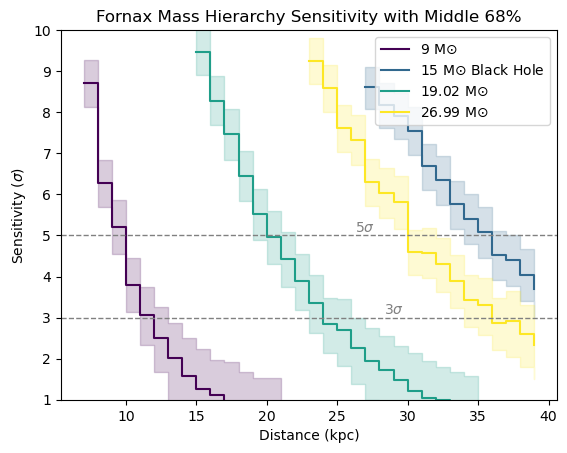

In [56]:
cmap = cm.viridis
norm1 = mcolors.Normalize(vmin=min(forn_masses_cut), vmax=max(forn_masses_cut))

for j,mod in enumerate(forn_masses_cut):
    prec_9_16=[]
    prec_9_84=[]
    sigs_9=[]
    dist_9=[]
    for i,dist in enumerate(forn_dist):
        if(dist[mod][0]<10 and dist[mod][0]>.5):
            sigs_9.append(dist[mod][0])
            dist_9.append(i+5)
            prec_9_16.append(dist[mod][1])
            prec_9_84.append(dist[mod][2])
        elif(dist[mod][0]<.5):
            break
            
    color = cmap(norm1(mod))
    if(mod==15):
        plt.step(dist_9,sigs_9,color=color,where='post',label='{} M$\odot$ Black Hole'.format(mod))
    else:
        plt.step(dist_9,sigs_9,color=color,where='post',label='{} M$\odot$'.format(mod))
    plt.fill_between(dist_9, prec_9_16, prec_9_84,step='post',color=color, alpha=0.2)

#sm = cm.ScalarMappable(cmap=cmap, norm=norm1)
#sm.set_array([])
#cbar = plt.colorbar(sm)
#cbar.set_label('Mass (M$\odot$)')

plt.axhline(y=3, color='grey', linestyle='--', linewidth=1)
plt.axhline(y=5, color='grey', linestyle='--', linewidth=1)
plt.text(27, 5.1, '5$\sigma$', color='grey', ha='center')
plt.text(29, 3.1, '3$\sigma$', color='grey', ha='center')

plt.legend()
plt.title('Fornax Mass Hierarchy Sensitivity with Middle 68%')
plt.ylabel('Sensitivity ($\sigma$)')
plt.xlabel('Distance (kpc)')
plt.ylim(1,10)


In [ ]:
for i,dist in enumerate(forn_dist):
        prec_9_16=[]
        prec_9_84=[]
        sigs_9=[]
        dist_9=[]
        if(dist[mod][0]<10 and dist[mod][0]>.5):
            sigs_9.append(dist[mod][0])
            dist_9.append(i+1)
            prec_9_16.append(dist[mod][1])
            prec_9_84.append(dist[mod][2])
        elif(dist[mod][0]<.5):
            break
            
    color = cmap(norm(mod))
    plt.step(dist_9,sigs_9,color=color,where='post',label='M=9.6')
    plt.fill_between(dist_9, prec_9_16, prec_9_84,step='post',color=color, alpha=0.2)